In [1]:
import types, param
if not hasattr(param, "reactive"):
    param.reactive = types.SimpleNamespace(rx=param.Parameterized)
del types, param

In [2]:
import json
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sys
import umap

from pathlib import Path
from typing import Dict, Sequence

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
mpl.style.use("default")

/projects/compsci/jgeorge/USERS/chouda/miniforge3/envs/keypoint_moseq_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import keypoint_moseq as kpms

In [4]:
sys.path.append(os.environ["UNSUPERVISED_AGING"] + "/src/kpms_utils")
from src.methods import load_and_format_data

In [5]:
unsupervised_aging_dir = Path(os.environ["UNSUPERVISED_AGING"])
kpms_dir               = unsupervised_aging_dir / "data/kpms_projects"
data_info_path         = unsupervised_aging_dir / "data/data_info.json"

with data_info_path.open("r") as f:
    data_info = json.load(f)

data = {}
for dataset, info in data_info.items():
    with Path(info["xcats_path"]).open("r") as f:
        xcats = json.load(f)
    data[dataset] = {
        "features": pd.read_csv(info["features_path"], index_col=0),
        "xcats": xcats,
        "results": pd.read_csv(info["model_eval_path"], index_col=0, low_memory=False)
    }
data_info

{'nature-aging_634': {'uid': 'nature-aging_634__2025-07-03_kpms-v2__2025-07-07_model-2',
  'dataset_dir': '/projects/kumar-lab/miaod/projects/unsupervised-aging/data/datasets/nature-aging_634',
  'kpms_project': '2025-07-03_kpms-v2',
  'kpms_model': '2025-07-07_model-2',
  'features_path': '/projects/kumar-lab/miaod/projects/unsupervised-aging/data/feature_matrices/2025-07-23_feature-matrix__nature-aging_634__2025-07-03_kpms-v2__2025-07-07_model-2.csv',
  'xcats_path': '/projects/kumar-lab/miaod/projects/unsupervised-aging/data/feature_matrices/2025-07-23_xcats__nature-aging_634__2025-07-03_kpms-v2__2025-07-07_model-2.json',
  'model_eval_path': '/projects/kumar-lab/miaod/projects/unsupervised-aging/data/model_evaluation_results/2025-07-24_model-evaluation-results__nature-aging_634__2025-07-03_kpms-v2__2025-07-07_model-2____n_repeats_5.csv'},
 'geroscience_492': {'uid': 'geroscience_492__2025-07-16_kpms-v3__2025-07-16_model-4',
  'dataset_dir': '/projects/kumar-lab/miaod/projects/unsup

/projects/compsci/jgeorge/USERS/chouda/miniforge3/envs/keypoint_moseq_gpu/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/projects/compsci/jgeorge/USERS/chouda/miniforge3/envs/keypoint_moseq_gpu/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/projects/compsci/jgeorge/USERS/chouda/miniforge3/envs/keypoint_moseq_gpu/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/projects/compsci/jgeorge/USERS

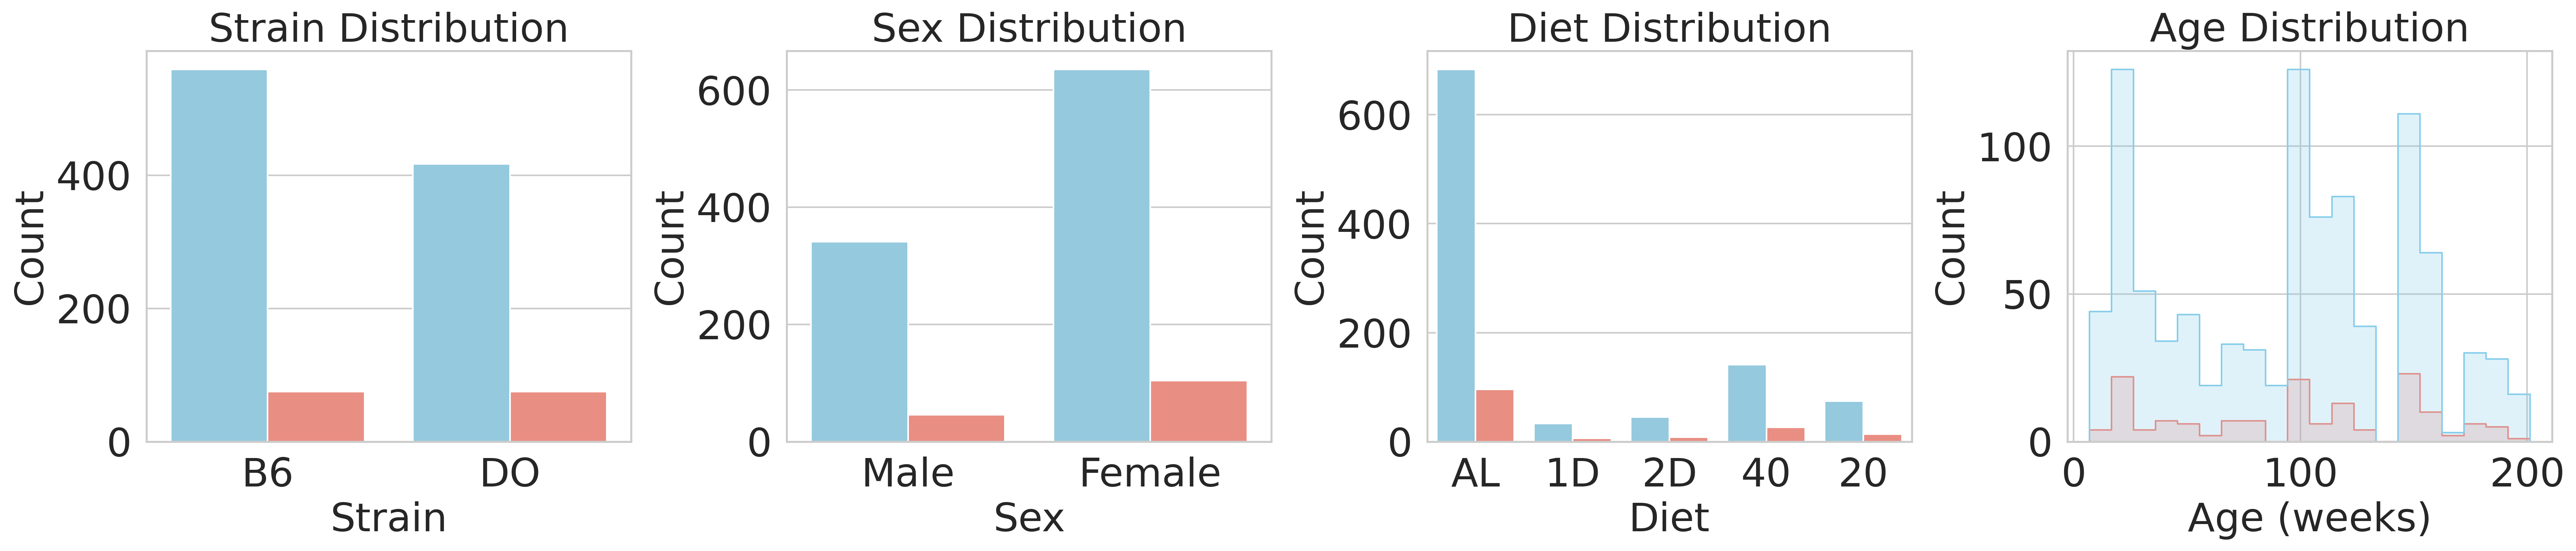

In [10]:
def _plot_kpms_training_set(
    dataset: str,
    kpms_training_dir: Path,
    text_size: int = 12,
    show_legend: bool = True
):
    df = data[dataset]["features"]
    kpms_training_set = [f.stem for f in kpms_training_dir.iterdir()]
    with open("temp.txt", "w") as f:
        for x in kpms_training_set:
            f.write(x + "\n")
    df["is_kpms"] = df["name"].isin(kpms_training_set)
    df["kpms_label"] = df["is_kpms"].map({False: "Combined Dataset", True: "Training Set"})

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharex=False, dpi=300)

    palette = {"Combined Dataset": "skyblue", "Training Set": "salmon"}
    common = {"data": df, "hue": "kpms_label", "palette": palette, "hue_order": ["Combined Dataset", "Training Set"]}

    sns.countplot(x="strain", ax=axes[0], **common)
    axes[0].set_title("Strain Distribution", fontsize=text_size)
    axes[0].set_xlabel("Strain", fontsize=text_size)
    axes[0].set_ylabel("Count", fontsize=text_size)

    sns.countplot(x="sex", ax=axes[1], **common)
    axes[1].set_title("Sex Distribution", fontsize=text_size)
    axes[1].set_xlabel("Sex", fontsize=text_size)
    axes[1].set_ylabel("Count", fontsize=text_size)

    sns.countplot(x="diet", ax=axes[2], **common)
    axes[2].set_title("Diet Distribution", fontsize=text_size)
    axes[2].set_xlabel("Diet", fontsize=text_size)
    axes[2].set_ylabel("Count", fontsize=text_size)

    sns.histplot(x="age", ax=axes[3], bins=20, element="step", stat="count", **common)
    axes[3].set_title("Age Distribution", fontsize=text_size)
    axes[3].set_xlabel("Age (weeks)", fontsize=text_size)
    axes[3].set_ylabel("Count", fontsize=text_size)

    for ax in axes:
        ax.tick_params(axis="both", labelsize=text_size)
        lg = ax.get_legend()
        if lg:
            lg.remove()

    if show_legend:
        handles = [mpatches.Patch(color=palette[k], label=k) for k in ["Combined Dataset", "Training Set"]]
        fig.legend(handles=handles, title="Dataset", loc="center left", bbox_to_anchor=(1.01, 0.5), borderaxespad=0.5, fontsize=text_size, title_fontsize=text_size)

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()



_plot_kpms_training_set(
    "combined_1126",
    unsupervised_aging_dir / "data/datasets/combined_1126/kpms_training_set_150_6/videos",
    text_size=25,
    show_legend=False,
)

In [11]:
legend_fig = plt.figure(figsize=(4, 1))
handles = [
    mpatches.Patch(color="skyblue", label="Combined Dataset"),
    mpatches.Patch(color="salmon", label="KPMS Training Set"),
]
legend_fig.legend(handles=handles, ncol=2, frameon=False, loc="center")
legend_fig.tight_layout()
plt.show()

<Figure size 400x100 with 0 Axes>

In [ ]:
_project_dir = kpms_dir / (data_info[dataset]["kpms_project"] + "_150")
combined_1126_results = kpms.load_results(_project_dir, data_info["combined_1126"]["kpms_model"])

In [ ]:
def _plot_syllable_length_distribution(
    dataset: str,
    th: float = 0.0,
    FPS: float = 30,
    log_scale: bool = False,
):
    results = combined_1126_results if dataset == "combined_1126" else None

    def _get_syllable_average_lengths(th: float = 0.01):
        sequences = [info["syllable"] for info in results.values()]
        uniq = sorted({s for seq in sequences for s in seq})

        if th > 0.0:
            global_counts = {s: 0 for s in uniq}
            for seq in sequences:
                for s in seq:
                    global_counts[s] += 1
            total = sum(global_counts.values())
            uniq = [s for s in uniq if global_counts[s] / total >= th]

        total_frames = {s: 0 for s in uniq}
        total_counts = {s: 0 for s in uniq}
        for _, info in mo.status.progress_bar(results.items()):
            syllables = info["syllable"]
            prev_s = None
            count = 0
            for s in list(syllables) + [None]:
                if s == prev_s:
                    count += 1
                else:
                    if prev_s in total_frames:
                        total_frames[prev_s] += count
                        total_counts[prev_s] += 1
                    prev_s = s
                    count = 1

        avg_lengths = {
            f"syllable_avg_length_{s}": (total_frames[s] / total_counts[s]) / FPS if total_counts[s] > 0 else 0.0
            for s in uniq
        }

        return avg_lengths

    avg_lengths = list(_get_syllable_average_lengths().values())
    avg_lengths = [val for val in avg_lengths if val < th]
    print(avg_lengths)

    plt.figure(figsize=(8, 5))
    sns.histplot(avg_lengths, kde=True, bins=30, color='skyblue', edgecolor='black')

    plt.title('Distribution of Average Syllable Lengths (in seconds)')
    plt.xlabel('Average Syllable Duration (s)')
    plt.ylabel('Frequency')
    if log_scale:
        plt.xscale('log')
        plt.xlabel('Log-Average Syllable Duration (s)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


_plot_syllable_length_distribution("combined_1126", th=2.1)

In [ ]:
def _plot_syllable_length_distribution(
    dataset: str,
    th: float = 0.0,
    FPS: float = 30,
    log_scale: bool = False,
    title = None,
    text_size: int = 12,
):
    project_dir = kpms_dir / (data_info[dataset]["kpms_project"] + "_150")
    results = combined_1126_results if dataset == "combined_1126" else None

    def _get_syllable_average_lengths(th: float = 0.01):
        sequences = [info["syllable"] for info in results.values()]
        uniq = sorted({s for seq in sequences for s in seq})
        if th > 0.0:
            global_counts = {s: 0 for s in uniq}
            for seq in sequences:
                for s in seq:
                    global_counts[s] += 1
            total = sum(global_counts.values())
            uniq = [s for s in uniq if global_counts[s] / total >= th]
        total_frames = {s: 0 for s in uniq}
        total_counts = {s: 0 for s in uniq}
        for _, info in mo.status.progress_bar(results.items()):
            syllables = info["syllable"]
            prev_s = None
            count = 0
            for s in list(syllables) + [None]:
                if s == prev_s:
                    count += 1
                else:
                    if prev_s in total_frames:
                        total_frames[prev_s] += count
                        total_counts[prev_s] += 1
                    prev_s = s
                    count = 1
        return {
            f"syllable_avg_length_{s}": (total_frames[s] / total_counts[s]) / FPS
            if total_counts[s] > 0
            else 0.0
            for s in uniq
        }

    avg_lengths = list(_get_syllable_average_lengths().values())
    avg_lengths = [v for v in avg_lengths if 0 < v < th] if th > 0 else [v for v in avg_lengths if v > 0]

    plt.figure(figsize=(8, 5))
    ax = sns.kdeplot(
        avg_lengths,
        fill=True,
        color="skyblue",
        linewidth=2,
        clip=(0, None),         # keep kernel strictly ≥ 0
        cut=0,                  # disable extension beyond data range
    )
    sns.despine(top=True, right=True)

    ax.set_xlim(left=min(avg_lengths))  # guarantees axis starts > 0
    if log_scale:
        ax.set_xscale("log")

    default_title = "Distribution of Average Syllable Lengths (in seconds)"
    if title:
        ax.set_title(title or default_title, fontsize=text_size)
    ax.set_xlabel(
        "Average Syllable Duration (s)" if not log_scale else "Log-Average Syllable Duration (s)",
        fontsize=text_size,
    )
    ax.set_ylabel("Frequency", fontsize=text_size)
    ax.tick_params(labelsize=text_size)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


_plot_syllable_length_distribution("combined_1126", th=2.1, title="", text_size=30)

In [ ]:
def plot_syllable_umap(
    dataset: str,
    metasyllable_groupings: Dict[str, Sequence[int]],
    spacing: int = 15,
    random_state: int = 623,
    border_color: str = "black",
    border_width: float = 0.5,
    text_size: int = 12,
    point_size: int = 30,
    fig_size = (8, 6),
    title: str = "UMAP Projection"
):
    project_dir = kpms_dir / (data_info[dataset]["kpms_project"] + "_150")
    results = kpms.load_results(project_dir, data_info[dataset]["kpms_model"])

    result_info = list(results.values())[0]
    embedding = umap.UMAP(random_state=random_state).fit_transform(
        result_info["latent_state"][::spacing]
    )

    group_names = list(metasyllable_groupings.keys())
    palette = ["red", "blue", "green", "orange", "purple"]
    palette_map = {g: c for g, c in zip(group_names, palette)}
    palette_map["unknown"] = "grey"

    labels = []
    for v in result_info["syllable"][::spacing]:
        for k, vals in metasyllable_groupings.items():
            if v in vals:
                labels.append(k)
                break
        else:
            labels.append("unknown")

    plt.figure(figsize=fig_size)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=palette_map,
        s=point_size,
        alpha=0.5,
        legend=False,
        linewidth=border_width,
        edgecolor=border_color
    )
    ax = plt.gca()
    ax.set_xlabel("UMAP 1", fontsize=text_size)
    ax.set_ylabel("UMAP 2", fontsize=text_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if title:
        plt.title(title, fontsize=text_size)
    plt.tight_layout()
    plt.show()

plot_syllable_umap("combined_1126", {
    "kpms_dendrogram_0": [41, 11, 23, 39, 22, 37, 28, 32, 5, 34, 1, 31, 20, 13, 25],
    "kpms_dendrogram_1": [45, 46],
    "kpms_dendrogram_2": [44, 50, 4, 2, 18, 53, 24, 8, 35, 14, 15, 10, 17, 26, 30, 7, 43, 9, 42, 48, 6, 29],
    "kpms_dendrogram_3": [47, 27, 36],
    "kpms_dendrogram_4": [40, 21, 12, 33, 16, 0, 3, 19, 38],
}, title="", text_size=20, border_width=0, border_color="white")

In [ ]:
from matplotlib.patches import Patch

def plot_meta_syllable_legend(
    border_color: str = "black",
    border_width: float = 0,
    text_size: int = 12
):
    colors = ["red", "blue", "green", "orange", "purple", "grey"]
    labels = [f"meta-syllable {i}" for i in range(5)] + ["other"]
    handles = [
        Patch(facecolor=c, edgecolor=border_color, linewidth=border_width)
        for c in colors
    ]
    fig, ax = plt.subplots(figsize=(2, 3))
    fig.legend(
        handles,
        labels,
        frameon=False,
        loc="center",
        ncol=1,
        fontsize=text_size,
        handlelength=2,
        handleheight=1
    )
    ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_meta_syllable_legend()

In [ ]:
import numpy as np
import networkx as nx
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from keypoint_moseq.util import syllable_similarity
from keypoint_moseq.io import _get_path

def plot_similarity_dendrogram_nx(
    coordinates,
    results,
    project_dir=None,
    model_name=None,
    save_path=None,
    metric="cosine",
    pre=0.167,
    post=0.5,
    min_frequency=0.005,
    min_duration=3,
    bodyparts=None,
    use_bodyparts=None,
    density_sample=False,
    sampling_options={"n_neighbors": 50},
    figsize=(8, 5),
    fps=None,
    **kwargs,
):
    """Plot a dendrogram using NetworkX instead of scipy dendrogram."""
    assert fps is not None, "fps must be provided"
    pre = round(pre * fps)
    post = round(post * fps)

    save_path = _get_path(project_dir, model_name, save_path, "similarity_dendrogram_nx")

    # Compute syllable similarity distances and linkage
    distances, syllable_ixs = syllable_similarity(
        coordinates,
        results,
        metric,
        pre,
        post,
        min_frequency,
        min_duration,
        bodyparts,
        use_bodyparts,
        density_sample,
        sampling_options,
    )

    Z = linkage(squareform(distances), method="complete")

    # Build tree from linkage
    G = nx.DiGraph()
    n_leaves = len(syllable_ixs)
    labels = {i: f"Syllable {s}" for i, s in enumerate(syllable_ixs)}
    node_heights = {}

    for i, (a, b, dist, _) in enumerate(Z):
        node_id = i + n_leaves
        G.add_edge(node_id, int(a))
        G.add_edge(node_id, int(b))
        node_heights[node_id] = dist

    # Assign y positions based on hierarchy (node height)
    pos = _hierarchy_pos(G, max(G.nodes), width=1.5)

    # Plot
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos=pos,
        labels={k: labels.get(k, "") for k in G.nodes},
        with_labels=True,
        node_size=50,
        font_size=8,
        font_color="black",
        edge_color="gray",
    )
    plt.title("Syllable similarity dendrogram (NetworkX)")
    plt.axis("off")

    print(f"Saving dendrogram plot to {save_path}")
    for ext in ["pdf", "png"]:
        plt.savefig(save_path + "." + ext)
    plt.close()


def _hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
    """
    Recursively position nodes in a hierarchy (for tree layout).
    Adapted from Joel's answer: https://stackoverflow.com/a/29597209/14792133
    """
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.successors(root))
    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(
                G, child, width=dx, vert_gap=vert_gap,
                vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root
            )
    return pos

In [ ]:

def plot_eml_scores(title="", text_size=10):

    scores = [
        166042173.01821983,
        166036128.81291834,
        165765359.7258733,
        165829234.22531214,
        165916952.09279424,
        165810696.35570186
    ]
    errs = [
        42774.5766267768,
        78139.78886585246,
        77105.10040717151,
        41309.1798708229,
        58107.56310842849,
        68526.79334683625
    ]
    scale = 1e8
    models = range(1, 7)
    s = [v / scale for v in scores]
    e = [v / scale for v in errs]
    lo = min(v - 2*d for v, d in zip(s, e))
    hi = max(v + 2*d for v, d in zip(s, e))

    plt.figure(figsize=(8, 5))
    plt.bar(models, s, yerr=e, capsize=4)
    plt.xticks(models, [str(m) for m in models], fontsize=text_size)
    plt.xlabel('Model', fontsize=text_size)
    plt.ylabel('EML Score (×10⁸)', fontsize=text_size)
    if title:
        plt.title(title, fontsize=text_size + 2)
    plt.ylim(lo, hi)
    plt.tick_params(axis='y', labelsize=text_size)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(False)

    plt.tight_layout()
    plt.show()

plot_eml_scores(text_size=30)